---
title: Generating queries for a domain specific language with LLMs - Part I
description: Improving user experience for creating filters by enabling natural language input with llms
date: 9-19-2024
categories:
  - llm
  - instructor
  - pydantic
  - openai
  - chatgpt
image: 'pg-btree.png'
format:
    html:
        toc: true
        toc-location: left
        number-sections: true
---

I was lucky enough to be part of the first (and only?) cohort for **the course** from [parlance labs](https://maven.com/parlance-labs/fine-tuning) and I was keen to get started on my use case for improving the the UX for a product feature I was working on. This is the first post of a series that will explore the use of LLMs to <s>*add ✨AI✨ *</s> add a natural language query feature and systematically evaluating and improving LLMs for this use case.

## Introducing the product feature

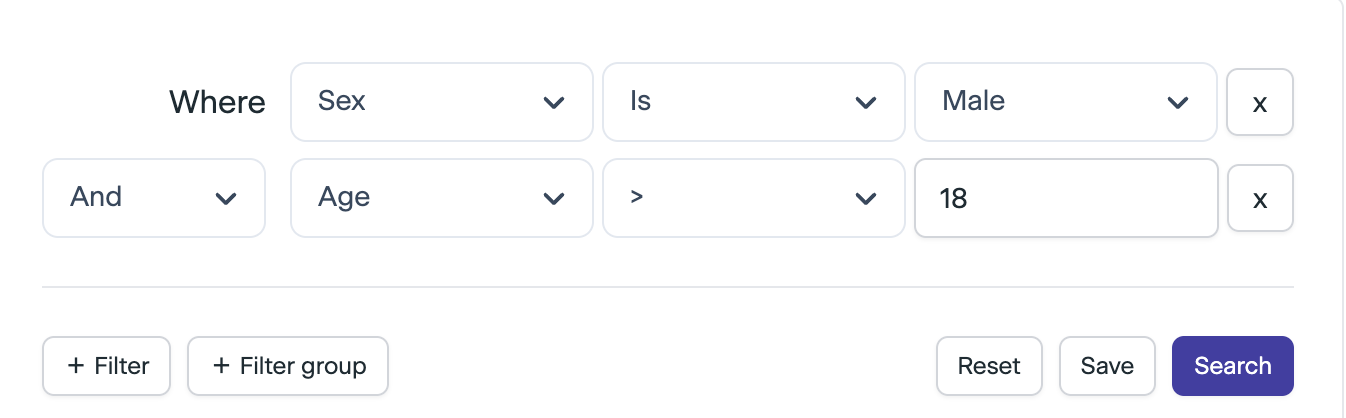

To find users, a feature on the platform allows admins to filter users by certain attributes. Currently this is achieved with a drop down with multiple inputs that are progressively rendered, depending on previous choices. In the example above, when the user sends the request to search users that match this query, the following query is sent to the backend:

```json
{
    "group_operator": "and",
    "children": [
        {
            "category": "user_sex",
            "operator": "equals",
            "value": "male"
        },
        {
            "category": "user_age",
            "operator": "greater_than",
            "value": "18"
        }
    ]
}
```

These expressions can be nested (infinitely!) to represent more complex queries:

```json
{
    "group_operator": "or",
    "children": [
        {
            "group_operator": "and",
            "children": [
                {
                    "category": "user_sex",
                    "operator": "equals",
                    "value": "male"
                },
                {
                    "category": "user_age",
                    "operator": "greater_than",
                    "value": "18"
                }
            ]
        },
        {
            "group_operator": "and",
            "children": [
                {
                    "category": "user_sex",
                    "operator": "equals",
                    "value": "female"
                },
                {
                    "category": "user_age",
                    "operator": "greater_than",
                    "value": "21"
                }
            ]
        }
    ]
}
```
*an example of a nested expression: the query above will find users who are  (male AND above 18) OR (female and above 21)*

The challenge with the existing UI is that it becomes difficult to find the type of filter you need, age and sex are easy enough to remember but the number of filter `categories` continues to increase, especially as the product increases in complexity with the increase in number of customers with different use cases. 

The goal of this project is to guide the user to choosing the correct filter, not to completely replace the existing UI. This hopefully avoids the trauma associated with the [dreaded sparkles](https://x.com/nearcyan/status/1783351706031718412) feature everyone seems to forcing onto users. The additional benefit is that it also provide us with useful training data so we can compare the generated filter with the actual filter sent to the backend after the user has had an opportunity to adjust the query with the dropdown UI, thus propelling our [data flywheel](https://www.sh-reya.com/blog/ai-engineering-flywheel/) to improve the model.

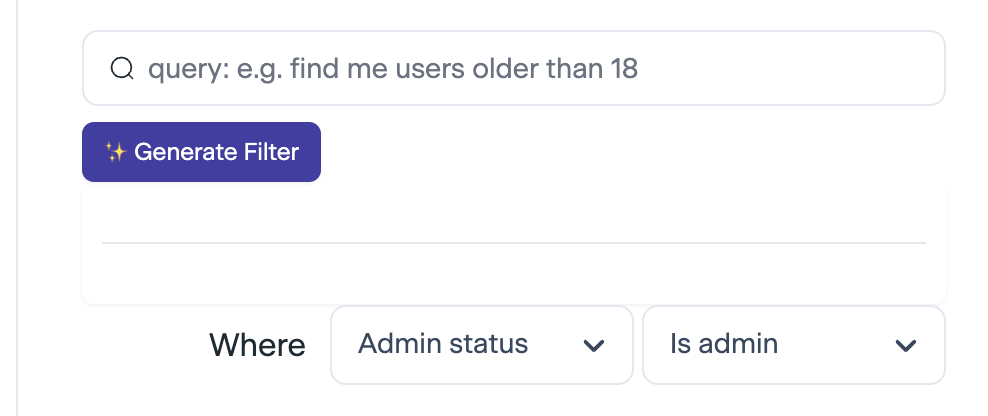

<i>we want to achieve something like this in our product</i>

# Starting with Simple & Stupid

Before committing to this project, it's important to gain a sense of what is possible with LLMs, so we can start by stripping down our use case to a small subset of the expression that we want to eventually support.

To get started, we'll first just try with the two filter expressions shown above: 'user_age' and 'user_sex' and see what the chatgpt gives us:

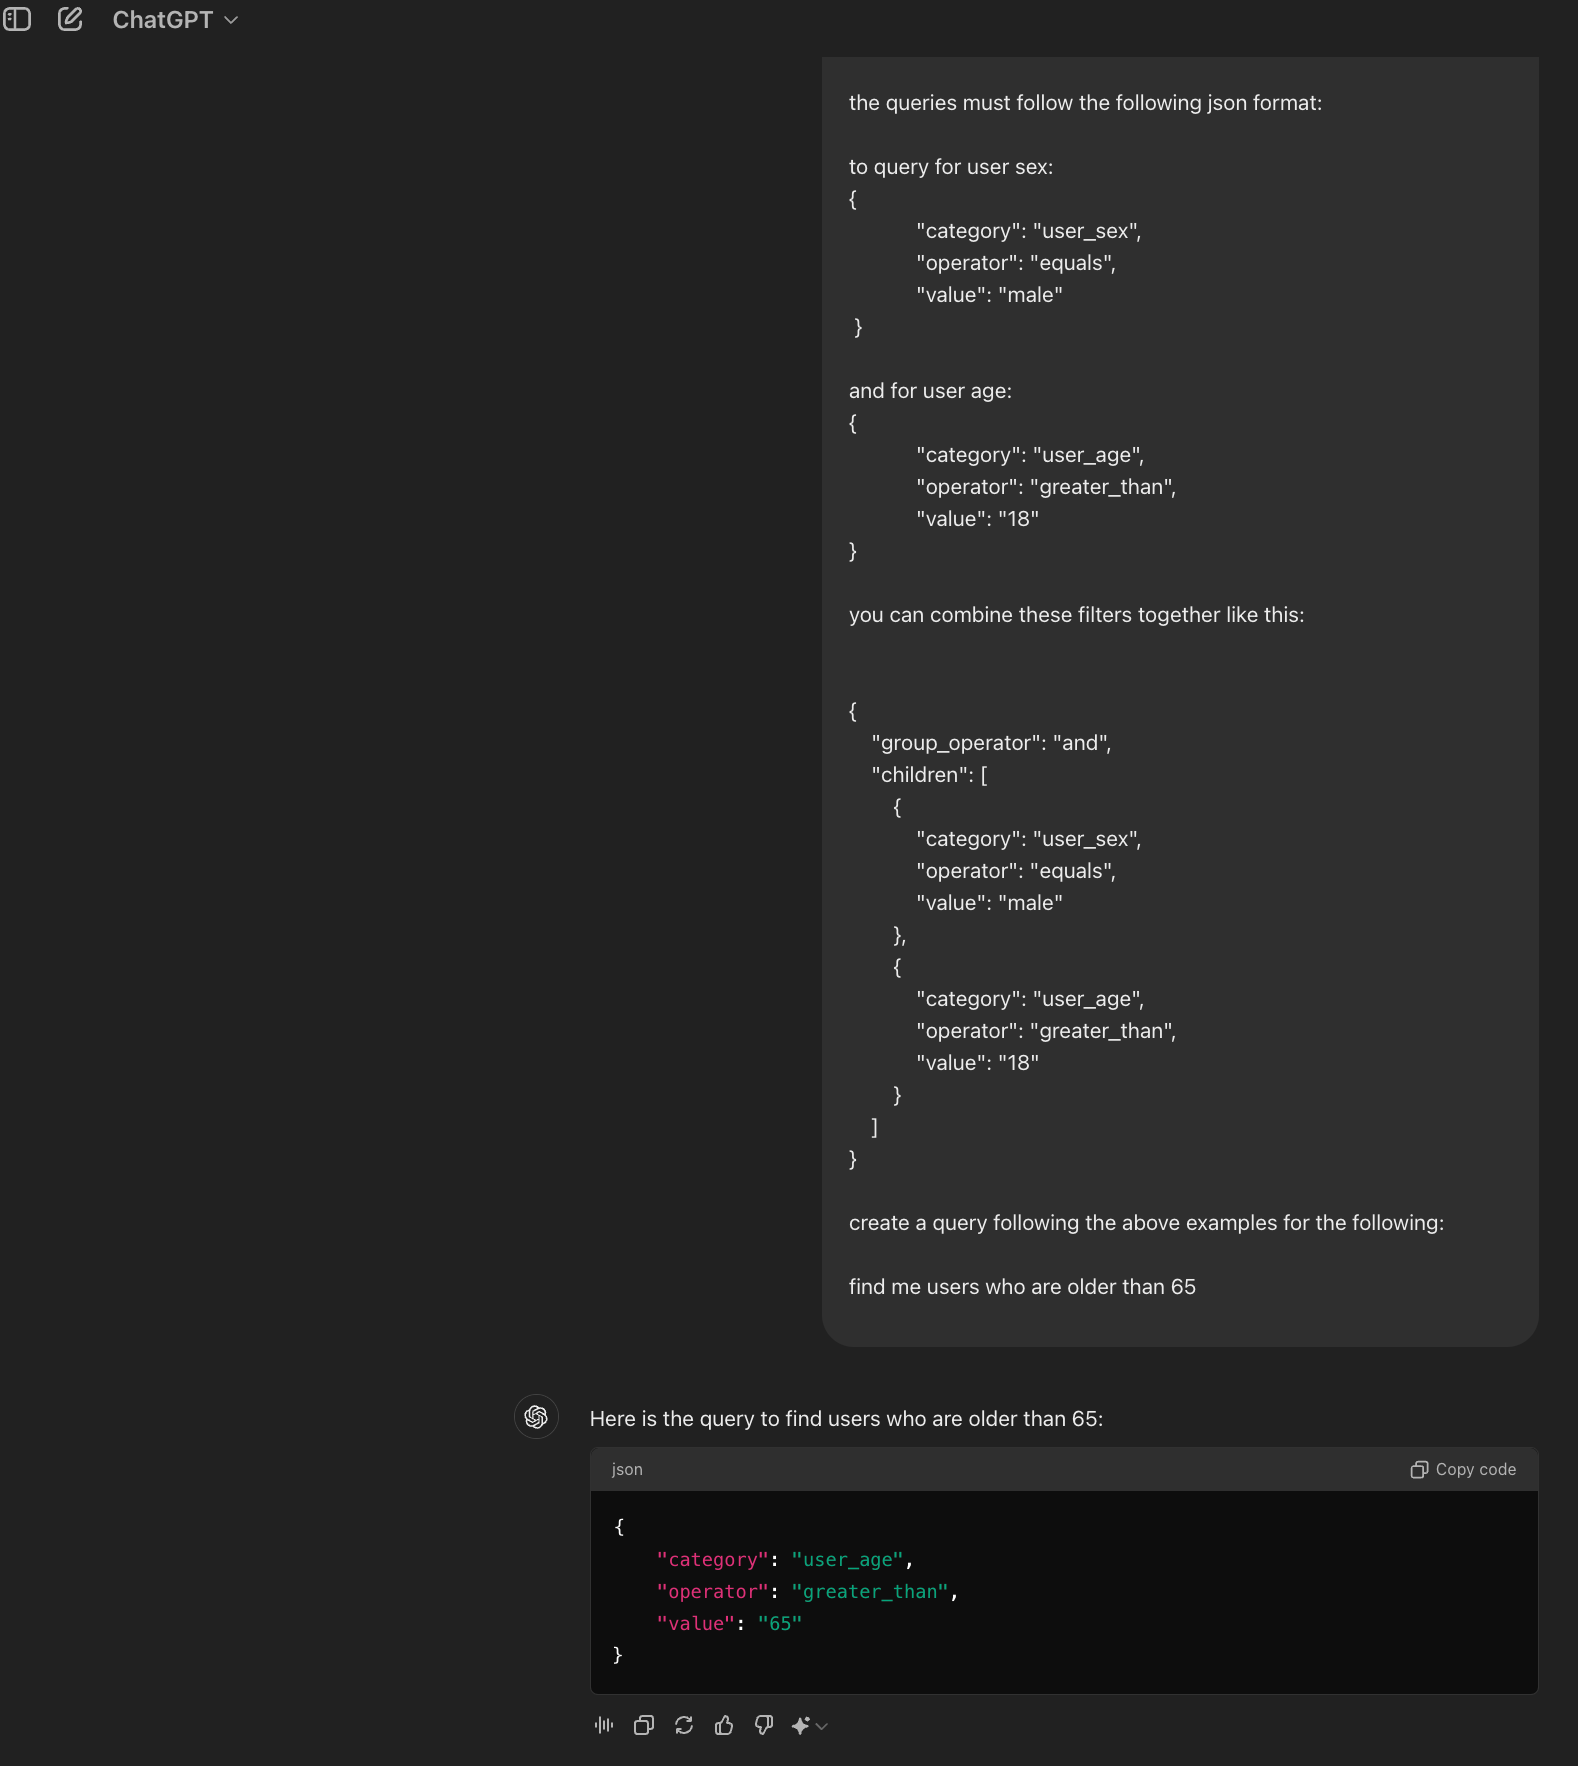


Even with just two types of filters, this looks very promising given that there was no fancy prompt engineering or other tricks (which we will explore later). Most importantly, it shows that this use case is feasible and is worth exploring a bit further.

Filter expressions are simply `json` objects so we can take advantage of the ecosystem around structured outputs for LLMs. To do this, we'll create `pydantic` models to represent these expressions.

OpenAI offers two routes to generating structured outputs: function calling and response format, [they recommend](https://platform.openai.com/docs/guides/structured-outputs/function-calling-vs-response-format) to use function calling when building an application so we'll use that to start with. To simplify the boilerplate around generating the function schemas, we'll define the json schemas with pydantic models and use the `instructor` [package](https://python.useinstructor.com/) to generate and send these with our openai API request. Hamel has a [great post](https://hamel.dev/blog/posts/prompt/#instructor) breaking down how `instructor` works and what it is actually doing behind the scenes. 

In [37]:
from enum import Enum
from typing import Union
from pydantic import BaseModel, SerializeAsAny


class GroupOperator(str, Enum):
    OR = "or"
    AND = "and"


class UserAgeOperators(str, Enum):
    GREATER_THAN = ">"
    LESS_THAN = "<"
    EQUALS = "="


class UserSex(str, Enum):
    MALE = "male"
    FEMALE = "female"


class Node(BaseModel):
    category: str
    operator: UserAgeOperators
    value: int


class UserAgeNode(Node):
    category: str = "user_age"
    value: int
    operator: str


class UserSexNode(Node):
    category: str = "user_sex"
    value: UserSex
    operator: str = "equals"


NodeTypes = Union[UserAgeNode, UserSexNode]


class Expression(BaseModel):
    group_operator: GroupOperator
    nodes: SerializeAsAny[
        list[Union["Expression", NodeTypes]]
    ]  # to support multiple levels of nested expressions

We can then represent the above expressions with a pydantic model instead of writing raw json ourselves:

In [38]:
from pprint import PrettyPrinter

pp = PrettyPrinter(width=40)

Expression(
    group_operator=GroupOperator.AND,
    nodes=[
        UserAgeNode(
            category="user_age", value=18, operator=UserAgeOperators.GREATER_THAN
        )
    ],
).model_dump(mode="json")

{'group_operator': 'and',
 'nodes': [{'category': 'user_age', 'operator': '>', 'value': 18}]}

we can generate then use this schema definition to make an API call to openai with function calling using `instructor`'s patched client:

In [39]:
import instructor
import openai
from dotenv import load_dotenv

load_dotenv()

client = instructor.from_openai(openai.OpenAI())

system_prompt = """you are an assistant to help generate filter expressions to search for users for a query.
Use the supplied tools to assist the user to generate a valid expression for the following query:"""

messages = []
messages.append({"role": "system", "content": system_prompt})
messages.append({"role": "user", "content": "find me users over the age of 18"})

response = client.chat.completions.create(
    model="gpt-4o-2024-08-06", messages=messages, response_model=Expression
)

pp.pprint(response)

Expression(group_operator=<GroupOperator.AND: 'and'>, nodes=[UserAgeNode(category='user_age', operator='greater_than', value=18)])


This gives us a valid pydantic model which we can then dump into the json format our query expects:

In [40]:
pp.pprint(response.model_dump(mode="json"))

{'group_operator': 'and',
 'nodes': [{'category': 'user_age',
            'operator': 'greater_than',
            'value': 18}]}


# Vibe checks

We can try out a few more examples and add some more filter categories to get a better sense of what llms are capable of and what kind of things they struggle with.

In [41]:
from datetime import date
from typing import Literal


class UserOccupationNode(Node):
    category: Literal["user_occupation"]
    value: str
    operator: Literal["equals"] = "equals"


class MartialStatuses(str, Enum):
    SINGLE = "single"
    MARRIED = "married"
    NOT_SINGLE = "not_single"
    DIVORCED = "divorced"
    WIDOWED = "widowed"


class UserMaritalStatusNode(Node):
    category: Literal["user_marital_status"] = "user_marital_status"
    value: MartialStatuses
    operator: Literal["equals"] = "equals"


class DateOperators(str, Enum):
    AFTER = "after"
    BEFORE = "before"
    ON = "on"


class UserJoinedDateNode(Node):
    category: Literal["user_joined_date"] = "user_joined_date"
    value: date
    operator: DateOperators


NodeTypes = Union[
    UserAgeNode,
    UserSexNode,
    UserOccupationNode,
    UserMaritalStatusNode,
    UserJoinedDateNode,
]


class Expression(BaseModel):
    group_operator: GroupOperator
    nodes: SerializeAsAny[list[Union["Expression", NodeTypes]]]

In [42]:
def generate_query(natural_language_query: str) -> Expression:
    system_prompt = """you are an assistant to help generate filter expressions
    to search for users for a query. Use the supplied tools to assist the user 
    to generate a valid expression for the following query:"""

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": natural_language_query},
    ]

    return client.chat.completions.create(
        model="gpt-4o-2024-08-06", messages=messages, response_model=Expression
    )


lets start with some simple single node queries just to make sure that the correct type of expression node is used:

In [43]:
expected_node = UserMaritalStatusNode
generated_query = generate_query("users who are married")

is_correct_node = isinstance(generated_query.nodes[0], expected_node)
pp.pprint(generated_query.model_dump(mode="json"))
print("✅") if is_correct_node else print("❌")

{'group_operator': 'or',
 'nodes': [{'category': 'user_marital_status',
            'operator': 'equals',
            'value': 'married'}]}
✅


we can bundle this code into a function so we can easily try a few prompts

In [44]:
def test_single_node(
    natural_language_query: str, expected_node: NodeTypes
) -> tuple[Expression, bool]:
    generated_query = generate_query(natural_language_query)
    if len(generated_query.nodes) != 1:
        # we only expect one node in the expression
        return generated_query, False
    return generated_query, isinstance(generated_query.nodes[0], expected_node)


def print_results(generated_query: Expression, is_correct_node: bool) -> None:
    pp.pprint(generated_query.model_dump(mode="json"))
    print("✅") if is_correct_node else print("❌")

In [45]:
generated_query, is_correct_node = test_single_node(
    "users who are married", UserMaritalStatusNode
)
print_results(generated_query, is_correct_node)

{'group_operator': 'and',
 'nodes': [{'category': 'user_marital_status',
            'operator': 'equals',
            'value': 'married'}]}
✅


In [46]:
expected_node = UserOccupationNode
query = "users who are doctors"
generated_query, is_correct_node = test_single_node(
    query, expected_node
    )
print_results(generated_query, is_correct_node)

{'group_operator': 'and',
 'nodes': [{'category': 'user_occupation',
            'operator': 'equals',
            'value': 'doctor'}]}
✅


In [47]:
expected_node = UserSexNode
query = "fetch all female users"

generated_query, is_correct_node = test_single_node(
    query, expected_node
    )
print_results(generated_query, is_correct_node)

{'group_operator': 'and',
 'nodes': [{'category': 'user_sex',
            'operator': 'equals',
            'value': 'female'}]}
✅


Lets up the ante, and try some expressions where we expect multiple nodes. We can create a new test function here to reduce the repetition

In [48]:
from collections import Counter


def test_multi_node(
    natural_language_query: str, expected_nodes: list[NodeTypes]
) -> tuple[Expression, bool]:
    generated_query = generate_query(natural_language_query)
    if len(generated_query.nodes) != len(expected_nodes):
        # we got more or less nodes than we expected
        return generated_query, False
    # check if the nodes are the same and have the same count
    is_correct_nodes = Counter(type(node) for node in generated_query.nodes) == Counter(
        expected_nodes
    )
    return generated_query, is_correct_nodes

In [49]:
generated_query, is_correct_nodes = test_multi_node(
    "joined in 2023", expected_nodes=[UserJoinedDateNode, UserJoinedDateNode]
)

print_results(generated_query, is_correct_nodes)

{'group_operator': 'and',
 'nodes': [{'category': 'user_joined_date',
            'operator': 'after',
            'value': '2022-12-31'}]}
❌


interestingly the llm wasn't able to correctly identify that we need two nodes to check that the joined date was after the end of 2022 AND before end of 2023

lets see if retrying helps:

In [50]:
is_correct_nodes = False
num_attempts = 0
while not is_correct_nodes:
    num_attempts += 1
    generated_query, is_correct_nodes = test_multi_node(
        "joined in 2023", expected_nodes=[UserJoinedDateNode, UserJoinedDateNode]
    )

print(f"{num_attempts=}")
print_results(generated_query, is_correct_nodes)

num_attempts=1
{'group_operator': 'and',
 'nodes': [{'category': 'user_joined_date',
            'operator': 'after',
            'value': '2023-01-01'},
           {'category': 'user_joined_date',
            'operator': 'before',
            'value': '2023-12-31'}]}
✅


In [51]:
generated_query, is_correct_nodes = test_multi_node(
    "find me female users over the age of 18", expected_nodes=[UserSexNode, UserAgeNode]
)
print_results(generated_query, is_correct_nodes)

{'group_operator': 'and',
 'nodes': [{'category': 'user_sex',
            'operator': 'equals',
            'value': 'female'},
           {'category': 'user_age',
            'operator': 'greater_than',
            'value': 18}]}
✅


# Integrating into the product

Even with such a simple and naive implementation, we can start testing out the system in the product to collect some data from users - i.e. what kind of natural language queries do our users try? It's also a lot more motivating to improve the model performance when it correlates directly with user satisfaction (or dissatisfaction!)

![updated filter ui with natural language query input](./ai-filters-blog.gif)

# Next Steps - Evals

We already introduced some simple tests in this post - `test_single_node` and `test_multi_node` look quite basic but the pydantic models (and `instructor`) are doing a lot of heavy lifting here to ensure that our model responses are valid expressions. 

In the next post, we'll build up our suite of evaluations and trying out more complex prompts to push this base model to its limits and identify more expression where <s>the model fails </s> we can improve the model.